<a href="https://colab.research.google.com/github/DianaDoosti/Introduction_to_AI_2025/blob/main/AI4032_MP3/MP3_Q7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Downloading and Loading the Pima Indians Diabetes Dataset




In [ ]:
import gdown
import pandas as pd

# Google Drive file ID
file_id = "17OoVzG1O6H_RuTwDHLeKbY7MiL9cLpSo"

# Construct URL for gdown
url = f"https://drive.google.com/uc?id={file_id}"

# Download the file as 'diabetes.csv'
output = "diabetes.csv"
gdown.download(url, output, quiet=False)

# Load the CSV into a DataFrame
df = pd.read_csv(output)


Downloading...
From: https://drive.google.com/uc?id=17OoVzG1O6H_RuTwDHLeKbY7MiL9cLpSo
To: /content/diabetes.csv
100%|██████████| 23.9k/23.9k [00:00<00:00, 37.3MB/s]


In [ ]:
# Show the first few rows
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


## Step 2: Data Preprocessing — Handling Missing Values, Splitting, and Scaling

In this step, we:
- Replace biologically implausible zero values with missing values (NaN) in specific columns,
- Split the dataset into training and test sets to prevent data leakage,
- Impute missing values using the median value (fitted only on the training set),
- Scale the features using standardization.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Step 1-3: Load and replace zeros with NaN (same as your code)
columns_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[columns_to_check] = df[columns_to_check].replace(0, np.nan)

# Step 4: Separate features and target before imputation and scaling
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Step 5: Split the data first to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Impute missing values using median imputer fitted on training data
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Step 7: Scale features using StandardScaler fitted on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Optional: Confirm shapes
print("Training data shape:", X_train_scaled.shape)
print("Test data shape:", X_test_scaled.shape)

Training data shape: (614, 8)
Test data shape: (154, 8)


## Step 3: Exporting Preprocessed Data to MATLAB `.mat` Format

In [ ]:
from scipy.io import savemat
import numpy as np

# Combine features and target into one array (last column is target)
data_for_matlab = np.hstack((X_train_scaled, y_train.values.reshape(-1, 1)))
test_data_for_matlab = np.hstack((X_test_scaled, y_test.values.reshape(-1, 1)))

# Save to .mat file
savemat("diabetes_train.mat", {"data": data_for_matlab})
savemat("diabetes_test.mat", {"data": test_data_for_matlab})

## Step 4: Implementing and Evaluating an MLP Neural Network with PyTorch

In this step, we implement, train, and evaluate a Multi-Layer Perceptron (MLP) neural network for binary diabetes classification using PyTorch. We also visualize the training loss curve and compute classification metrics on the test set.

DiabetesClassificationModel(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


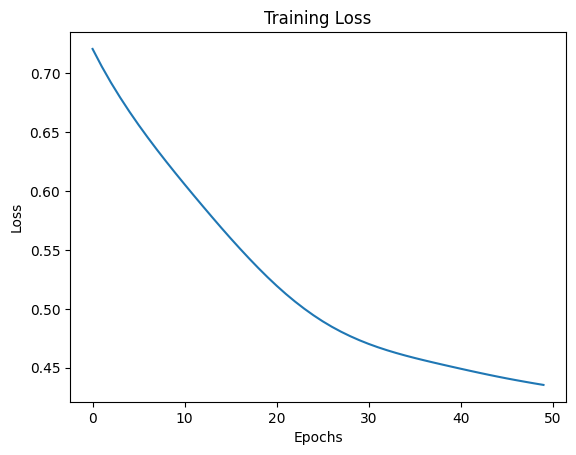

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Define the neural network architecture for binary classification
class DiabetesClassificationModel(nn.Module):
    def __init__(self, input_dim):
        super(DiabetesClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 64)         # Second fully connected layer
        self.fc3 = nn.Linear(64, 1)           # Output layer, 1 output for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))   # Apply ReLU activation after the first layer
        x = torch.relu(self.fc2(x))   # Apply ReLU activation after the second layer
        x = torch.sigmoid(self.fc3(x))  # Sigmoid activation for binary classification
        return x

# Initialize the model (assuming the input dimension is the number of features)
input_dim = X_train_scaled.shape[1]  # Number of features in your dataset
output_dim = 1  # Binary output: diabetes or no diabetes (0 or 1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiabetesClassificationModel(input_dim).to(device)

# Print model architecture
print(model)

# Training Parameters
n_epochs = 50
learning_rates = [1, 1e-3, 1e-8]

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rates[1])
criterion = nn.BCELoss()  # Binary Cross-Entropy loss

# Convert data to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Training loop
train_losses = []
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    # Backward pass
    loss.backward()
    optimizer.step()

    # Store the training loss
    train_losses.append(loss.item())

    # Print loss every 10 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")

# Evaluation
model.eval()

# Predict on test data
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    y_pred_test = (y_pred_test > 0.5).float()  # Convert predictions to binary (0 or 1)

# Optional: Plot training loss curve
plt.plot(range(n_epochs), train_losses)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Print evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test_tensor.cpu(), y_pred_test.cpu()))
# Compute confusion matrix
cm = confusion_matrix(y_test_tensor.cpu(), y_pred_test.cpu())

print("\nConfusion Matrix:")
print(cm)

# Extract values
TN, FP, FN, TP = cm.ravel()

# Calculate metrics
sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

print(f"\nSensitivity (Recall / True Positive Rate): {sensitivity:.4f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")


Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83        99
         1.0       0.71      0.64      0.67        55

    accuracy                           0.78       154
   macro avg       0.76      0.75      0.75       154
weighted avg       0.78      0.78      0.78       154


Confusion Matrix:
[[85 14]
 [20 35]]

Sensitivity (Recall / True Positive Rate): 0.6364
Specificity (True Negative Rate): 0.8586
